# Day 3 作业--Pixel2Pixel：人像卡通化

经过今天的学习，相信大家对图像翻译、风格迁移有了一定的了解啦，是不是也想自己动手来实现下呢？

那么，为了满足大家动手实践的愿望，同时为了巩固大家学到的知识，我们Day 3的作业便是带大家完成一遍课程讲解过的应用--**Pixel2Pixel：人像卡通化**

在本次作业中，大家需要做的是：**补齐代码，跑通训练，提交一张卡通化的成品图，动手完成自己的第一个人像卡通化的应用~**

![](https://ai-studio-static-online.cdn.bcebos.com/6e3af14bf9f847ab92215753fb3b8f61a66186b538f44da78ca56627c35717b8)

## 准备工作：引入依赖 & 数据准备

In [1]:
import paddle
import paddle.nn as nn
from paddle.io import Dataset, DataLoader

import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


### 数据准备：

- 真人数据来自[seeprettyface](http://www.seeprettyface.com/mydataset.html)。
- 数据预处理（详情见[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目）。
<div>
  <img src='https://ai-studio-static-online.cdn.bcebos.com/c56c889827534363a8b6909d7737a1da64635ad33e1e44cb822f4c1cf1dfc689' height='1000px' width='1000px'>
</div>

- 使用[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目生成真人数据对应的卡通数据。

In [2]:
# 解压数据
!unzip -q data/data79149/cartoon_A2B.zip -d data/

### 数据可视化

训练集数据量: 1361
测试集数据量: 100


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


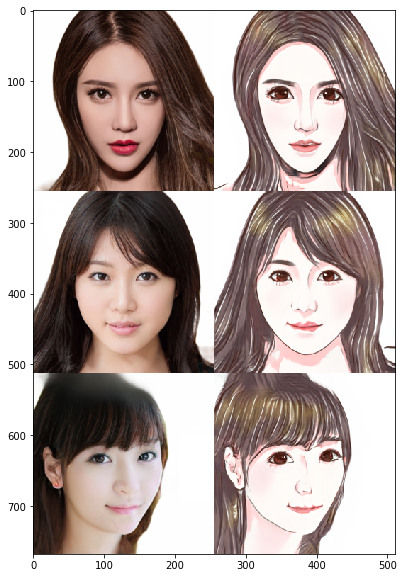

In [3]:
# 训练数据统计
train_names = os.listdir('data/cartoon_A2B/train')
print(f'训练集数据量: {len(train_names)}')

# 测试数据统计
test_names = os.listdir('data/cartoon_A2B/test')
print(f'测试集数据量: {len(test_names)}')

# 训练数据可视化
imgs = []
for img_name in np.random.choice(train_names, 3, replace=False):
    imgs.append(cv2.imread('data/cartoon_A2B/train/'+img_name))

img_show = np.vstack(imgs)[:,:,::-1]
plt.figure(figsize=(10, 10))
plt.imshow(img_show)
plt.show()

In [4]:
class PairedData(Dataset):
    def __init__(self, phase):
        super(PairedData, self).__init__() 
        self.img_path_list = self.load_A2B_data(phase)    # 获取数据列表
        self.num_samples = len(self.img_path_list)        # 数据量

    def __getitem__(self, idx):
        img_A2B = cv2.imread(self.img_path_list[idx])                                        # 读取一组数据
        img_A2B = img_A2B.astype('float32') / 127.5 - 1                                        # 从0~255归一化至-1~1
        img_A2B = img_A2B.transpose(2,0,1)                                        # 维度变换HWC -> CHW
        img_A = img_A2B[..., :256]                                          # 真人照
        img_B = img_A2B[..., 256:]                                          # 卡通图
        return img_A, img_B

    def __len__(self):
        return self.num_samples

    @staticmethod
    def load_A2B_data(phase):
        assert phase in ['train', 'test'], "phase should be set within ['train', 'test']"
        # 读取数据集，数据中每张图像包含照片和对应的卡通画。
        data_path = 'data/cartoon_A2B/'+phase
        return [os.path.join(data_path, x) for x in os.listdir(data_path)]

In [5]:
paired_dataset_train = PairedData('train')
paired_dataset_test = PairedData('test')

## 第一步：搭建生成器


In [6]:
class UnetGenerator(nn.Layer):
    def __init__(self, input_nc=3, output_nc=3, ngf=64):
        super(UnetGenerator, self).__init__()

        self.down1 = nn.Conv2D(input_nc, ngf, kernel_size=4, stride=2, padding=1)
        self.down2 = Downsample(ngf, ngf*2)
        self.down3 = Downsample(ngf*2, ngf*4)
        self.down4 = Downsample(ngf*4, ngf*8)
        self.down5 = Downsample(ngf*8, ngf*8)
        self.down6 = Downsample(ngf*8, ngf*8)
        self.down7 = Downsample(ngf*8, ngf*8)

        self.center = Downsample(ngf*8, ngf*8)

        self.up7 = Upsample(ngf*8, ngf*8, use_dropout=True)
        self.up6 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up5 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up4 = Upsample(ngf*8*2, ngf*8)
        self.up3 = Upsample(ngf*8*2, ngf*4)
        self.up2 = Upsample(ngf*4*2, ngf*2)
        self.up1 = Upsample(ngf*2*2, ngf)

        self.output_block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2DTranspose(ngf*2, output_nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        
        c = self.center(d7)
        
        x = self.up7(c, d7)
        x = self.up6(x, d6)
        x = self.up5(x, d5)
        x = self.up4(x, d4)
        x = self.up3(x, d3)
        x = self.up2(x, d2)
        x = self.up1(x, d1)

        x = self.output_block(x)
        return x


class Downsample(nn.Layer):
    # LeakyReLU => conv => batch norm
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(Downsample, self).__init__()

        self.layers = nn.Sequential(
            nn.LeakyReLU(0.2),                        # LeakyReLU, leaky=0.2
            nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),#偏置                    # Conv2D
            nn.BatchNorm2D(out_dim)                    # BatchNorm2D
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class Upsample(nn.Layer):
    # ReLU => deconv => batch norm => dropout
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1, use_dropout=False):
        super(Upsample, self).__init__()

        sequence = [
            nn.ReLU(),                    # ReLU
            nn.Conv2DTranspose(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),                    # Conv2DTranspose
            nn.BatchNorm2D(out_dim)                    # nn.BatchNorm2D
        ]

        if use_dropout:
            sequence.append(nn.Dropout(p=0.5))

        self.layers = nn.Sequential(*sequence)

    def forward(self, x, skip):
        x = self.layers(x)
        x = paddle.concat([x, skip], axis=1)
        return x

## 第二步：鉴别器的搭建


In [7]:
class NLayerDiscriminator(nn.Layer):
    def __init__(self, input_nc=6, ndf=64):
        super(NLayerDiscriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2D(input_nc, ndf, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.2),
            
            ConvBlock(ndf, ndf*2),
            ConvBlock(ndf*2, ndf*4),
            ConvBlock(ndf*4, ndf*8, stride=1),

            nn.Conv2D(ndf*8, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.layers(input)


class ConvBlock(nn.Layer):
    # conv => batch norm => LeakyReLU
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(ConvBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),                    # Conv2D
            nn.BatchNorm2D(out_dim),                    # BatchNorm2D
            nn.LeakyReLU(0.2)                    # LeakyReLU, leaky=0.2
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [8]:
generator = UnetGenerator()
discriminator = NLayerDiscriminator()

In [9]:
out = generator(paddle.ones([1, 3, 256, 256]))
print('生成器输出尺寸：', out.shape)  # 应为[1, 3, 256, 256]

out = discriminator(paddle.ones([1, 6, 256, 256]))
print('鉴别器输出尺寸：', out.shape)  # 应为[1, 1, 30, 30]

生成器输出尺寸： [1, 3, 256, 256]
鉴别器输出尺寸： [1, 1, 30, 30]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


In [10]:
# 超参数
LR = 1e-4
BATCH_SIZE = 8
EPOCHS = 100

# 优化器
optimizerG = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=generator.parameters(),
    beta1=0.5,
    beta2=0.999)

optimizerD = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=discriminator.parameters(), 
    beta1=0.5,
    beta2=0.999)
    
# 损失函数
bce_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# dataloader
data_loader_train = DataLoader(
    paired_dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
    )

data_loader_test = DataLoader(
    paired_dataset_test,
    batch_size=BATCH_SIZE
    )

In [11]:
results_save_path = 'work/results'
os.makedirs(results_save_path, exist_ok=True)  # 保存每个epoch的测试结果

weights_save_path = 'work/weights'
os.makedirs(weights_save_path, exist_ok=True)  # 保存模型

for epoch in range(EPOCHS):
    for data in tqdm(data_loader_train):
        real_A, real_B = data
        
        optimizerD.clear_grad()
        # D([real_A, real_B])
        real_AB = paddle.concat((real_A, real_B), 1)
        d_real_predict = discriminator(real_AB)
        d_real_loss = bce_loss(d_real_predict, paddle.ones_like(d_real_predict))

        # D([real_A, fake_B])
        fake_B = generator(real_A).detach()
        fake_AB = paddle.concat((real_A, fake_B), 1)
        d_fake_predict = discriminator(fake_AB)
        d_fake_loss = bce_loss(d_fake_predict, paddle.zeros_like(d_fake_predict))
        
        # train D
        d_loss = (d_real_loss + d_fake_loss) / 2.
        d_loss.backward()
        optimizerD.step()

        optimizerG.clear_grad()
        # D([real_A, fake_B])
        fake_B = generator(real_A)
        fake_AB = paddle.concat((real_A, fake_B), 1)
        g_fake_predict = discriminator(fake_AB)
        g_bce_loss = bce_loss(g_fake_predict, paddle.ones_like(g_fake_predict))
        g_l1_loss = l1_loss(fake_B, real_B) * 100.
        g_loss = g_bce_loss + g_l1_loss
        
        # train G
        g_loss.backward()
        optimizerG.step()

    print(f'Epoch [{epoch+1}/{EPOCHS}] Loss D: {d_loss.numpy()}, Loss G: {g_loss.numpy()}')

    if (epoch+1) % 10 == 0:
        paddle.save(generator.state_dict(), os.path.join(weights_save_path, 'epoch'+str(epoch+1).zfill(3)+'.pdparams'))

        # test
        generator.eval()
        with paddle.no_grad():
            for data in data_loader_test:
                real_A, real_B = data
                break

            fake_B = generator(real_A)
            result = paddle.concat([real_A[:3], real_B[:3], fake_B[:3]], 3)

            result = result.detach().numpy().transpose(0, 2, 3, 1)
            result = np.vstack(result)
            result = (result * 127.5 + 127.5).astype(np.uint8)
    
        cv2.imwrite(os.path.join(results_save_path, 'epoch'+str(epoch+1).zfill(3)+'.png'), result)

        generator.train()

  1%|          | 1/170 [00:00<00:24,  6.84it/s]

Epoch [1/100] Loss D: [0.5154941], Loss G: [13.136808]


  1%|          | 1/170 [00:00<00:26,  6.48it/s]

Epoch [2/100] Loss D: [0.5482019], Loss G: [11.207237]


  1%|          | 1/170 [00:00<00:24,  6.91it/s]

Epoch [3/100] Loss D: [0.60862243], Loss G: [11.621727]


  1%|          | 1/170 [00:00<00:24,  6.87it/s]

Epoch [4/100] Loss D: [0.5098654], Loss G: [11.42052]


  1%|          | 1/170 [00:00<00:26,  6.35it/s]

Epoch [5/100] Loss D: [0.56193376], Loss G: [11.56463]


  1%|          | 1/170 [00:00<00:30,  5.50it/s]

Epoch [6/100] Loss D: [0.68425167], Loss G: [10.863463]


  1%|          | 1/170 [00:00<00:27,  6.11it/s]

Epoch [7/100] Loss D: [0.6744995], Loss G: [10.642251]


  1%|          | 1/170 [00:00<00:27,  6.23it/s]

Epoch [8/100] Loss D: [0.66459036], Loss G: [10.274683]


  1%|          | 1/170 [00:00<00:27,  6.25it/s]

Epoch [9/100] Loss D: [0.45505172], Loss G: [9.5097065]


  1%|          | 2/170 [00:00<00:25,  6.59it/s]100%|██████████| 170/170 [00:23<00:00,  7.32it/s]


Epoch [10/100] Loss D: [0.5726921], Loss G: [9.549263]


  1%|          | 1/170 [00:00<00:25,  6.52it/s]

Epoch [11/100] Loss D: [0.59572494], Loss G: [9.561091]


  1%|          | 1/170 [00:00<00:26,  6.49it/s]

Epoch [12/100] Loss D: [0.65218985], Loss G: [9.355462]


  1%|          | 1/170 [00:00<00:25,  6.60it/s]

Epoch [13/100] Loss D: [0.72201335], Loss G: [9.052158]


  1%|          | 1/170 [00:00<00:24,  6.77it/s]

Epoch [14/100] Loss D: [0.6421864], Loss G: [9.20406]


  1%|          | 1/170 [00:00<00:29,  5.75it/s]

Epoch [15/100] Loss D: [0.606632], Loss G: [8.6380625]


  1%|          | 1/170 [00:00<00:26,  6.38it/s]

Epoch [16/100] Loss D: [0.58655757], Loss G: [8.371473]


  1%|          | 1/170 [00:00<00:26,  6.32it/s]

Epoch [17/100] Loss D: [0.68617845], Loss G: [8.486839]


  1%|          | 1/170 [00:00<00:31,  5.39it/s]

Epoch [18/100] Loss D: [0.63441724], Loss G: [8.125991]


  1%|          | 1/170 [00:00<00:26,  6.35it/s]

Epoch [19/100] Loss D: [0.60697675], Loss G: [7.6650753]


  1%|          | 2/170 [00:00<00:25,  6.52it/s]100%|██████████| 170/170 [00:23<00:00,  7.29it/s]


Epoch [20/100] Loss D: [0.6624658], Loss G: [7.593706]


  1%|          | 1/170 [00:00<00:25,  6.54it/s]

Epoch [21/100] Loss D: [0.62009466], Loss G: [8.019876]


  1%|          | 1/170 [00:00<00:27,  6.11it/s]

Epoch [22/100] Loss D: [0.662388], Loss G: [8.06205]


  1%|          | 1/170 [00:00<00:25,  6.66it/s]

Epoch [23/100] Loss D: [0.6540335], Loss G: [7.0066924]


  1%|          | 1/170 [00:00<00:26,  6.42it/s]

Epoch [24/100] Loss D: [0.6557778], Loss G: [7.289026]


  1%|          | 1/170 [00:00<00:25,  6.58it/s]

Epoch [25/100] Loss D: [0.65289485], Loss G: [7.217415]


  1%|          | 1/170 [00:00<00:26,  6.33it/s]

Epoch [26/100] Loss D: [0.6104007], Loss G: [7.1380706]


  1%|          | 1/170 [00:00<00:25,  6.52it/s]

Epoch [27/100] Loss D: [0.63422275], Loss G: [6.539509]


  1%|          | 1/170 [00:00<00:26,  6.44it/s]

Epoch [28/100] Loss D: [0.61588264], Loss G: [6.899269]


  1%|          | 1/170 [00:00<00:26,  6.30it/s]

Epoch [29/100] Loss D: [0.6309939], Loss G: [6.52989]


  1%|          | 2/170 [00:00<00:25,  6.63it/s]100%|██████████| 170/170 [00:23<00:00,  7.30it/s]


Epoch [30/100] Loss D: [0.5866978], Loss G: [7.044882]


  1%|          | 1/170 [00:00<00:25,  6.53it/s]

Epoch [31/100] Loss D: [0.62648225], Loss G: [6.3469524]


  1%|          | 1/170 [00:00<00:27,  6.25it/s]

Epoch [32/100] Loss D: [0.59072953], Loss G: [6.093707]


  1%|          | 1/170 [00:00<00:25,  6.73it/s]

Epoch [33/100] Loss D: [0.64846545], Loss G: [6.230219]


  1%|          | 1/170 [00:00<00:29,  5.78it/s]

Epoch [34/100] Loss D: [0.6145583], Loss G: [6.048646]


  1%|          | 1/170 [00:00<00:28,  5.94it/s]

Epoch [35/100] Loss D: [0.6514225], Loss G: [5.937655]


  1%|          | 1/170 [00:00<00:26,  6.38it/s]

Epoch [36/100] Loss D: [0.623234], Loss G: [5.90354]


  1%|          | 1/170 [00:00<00:27,  6.04it/s]

Epoch [37/100] Loss D: [0.6111951], Loss G: [5.8876367]


  1%|          | 1/170 [00:00<00:26,  6.49it/s]

Epoch [38/100] Loss D: [0.6190449], Loss G: [5.9093943]


  1%|          | 1/170 [00:00<00:24,  6.80it/s]

Epoch [39/100] Loss D: [0.6218387], Loss G: [5.740712]


  1%|          | 2/170 [00:00<00:24,  6.98it/s]100%|██████████| 170/170 [00:23<00:00,  7.30it/s]


Epoch [40/100] Loss D: [0.6426454], Loss G: [5.68715]


  1%|          | 1/170 [00:00<00:26,  6.27it/s]

Epoch [41/100] Loss D: [0.61804765], Loss G: [5.5366354]


  1%|          | 1/170 [00:00<00:27,  6.05it/s]

Epoch [42/100] Loss D: [0.65719914], Loss G: [5.549535]


  1%|          | 1/170 [00:00<00:25,  6.67it/s]

Epoch [43/100] Loss D: [0.647074], Loss G: [5.523381]


  1%|          | 1/170 [00:00<00:27,  6.24it/s]

Epoch [44/100] Loss D: [0.6637384], Loss G: [5.6364846]


  1%|          | 1/170 [00:00<00:24,  6.80it/s]

Epoch [45/100] Loss D: [0.77412105], Loss G: [5.667744]


  1%|          | 1/170 [00:00<00:27,  6.12it/s]

Epoch [46/100] Loss D: [0.6317627], Loss G: [5.6576285]


  1%|          | 1/170 [00:00<00:26,  6.29it/s]

Epoch [47/100] Loss D: [0.7141162], Loss G: [4.9941163]


  1%|          | 1/170 [00:00<00:26,  6.49it/s]

Epoch [48/100] Loss D: [0.6625774], Loss G: [5.0841436]


  1%|          | 1/170 [00:00<00:27,  6.15it/s]

Epoch [49/100] Loss D: [0.6793675], Loss G: [5.6554346]


  1%|          | 2/170 [00:00<00:25,  6.55it/s]100%|██████████| 170/170 [00:23<00:00,  7.33it/s]


Epoch [50/100] Loss D: [0.68272316], Loss G: [5.42616]


  1%|          | 1/170 [00:00<00:26,  6.34it/s]

Epoch [51/100] Loss D: [0.6590893], Loss G: [4.8694615]


  1%|          | 1/170 [00:00<00:25,  6.74it/s]

Epoch [52/100] Loss D: [0.66015494], Loss G: [5.5928674]


  1%|          | 1/170 [00:00<00:25,  6.57it/s]

Epoch [53/100] Loss D: [0.6539848], Loss G: [5.1037455]


  1%|          | 1/170 [00:00<00:26,  6.43it/s]

Epoch [54/100] Loss D: [0.63344026], Loss G: [4.930896]


  1%|          | 1/170 [00:00<00:24,  6.85it/s]

Epoch [55/100] Loss D: [0.65288603], Loss G: [4.8504558]


  1%|          | 1/170 [00:00<00:25,  6.70it/s]

Epoch [56/100] Loss D: [0.6519495], Loss G: [4.9751997]


  1%|          | 1/170 [00:00<00:25,  6.54it/s]

Epoch [57/100] Loss D: [0.6439678], Loss G: [5.20967]


  1%|          | 1/170 [00:00<00:25,  6.66it/s]

Epoch [58/100] Loss D: [0.63391376], Loss G: [5.1687126]


  1%|          | 1/170 [00:00<00:24,  7.01it/s]

Epoch [59/100] Loss D: [0.6679269], Loss G: [5.0767655]


  1%|          | 2/170 [00:00<00:23,  7.13it/s]100%|██████████| 170/170 [00:23<00:00,  7.32it/s]


Epoch [60/100] Loss D: [0.68600965], Loss G: [4.9552813]


  1%|          | 1/170 [00:00<00:26,  6.26it/s]

Epoch [61/100] Loss D: [0.66282976], Loss G: [5.0068207]


  1%|          | 1/170 [00:00<00:28,  6.00it/s]

Epoch [62/100] Loss D: [0.6663798], Loss G: [4.675892]


  1%|          | 1/170 [00:00<00:25,  6.59it/s]

Epoch [63/100] Loss D: [0.6620504], Loss G: [4.969228]


  1%|          | 1/170 [00:00<00:29,  5.69it/s]

Epoch [64/100] Loss D: [0.61302495], Loss G: [4.9278193]


  1%|          | 1/170 [00:00<00:24,  6.92it/s]

Epoch [65/100] Loss D: [0.6440253], Loss G: [4.826386]


  1%|          | 1/170 [00:00<00:26,  6.27it/s]

Epoch [66/100] Loss D: [0.6778144], Loss G: [4.859073]


  1%|          | 1/170 [00:00<00:27,  6.18it/s]

Epoch [67/100] Loss D: [0.66201687], Loss G: [4.62252]


  1%|          | 1/170 [00:00<00:29,  5.81it/s]

Epoch [68/100] Loss D: [0.67181814], Loss G: [4.768273]


  1%|          | 1/170 [00:00<00:29,  5.67it/s]

Epoch [69/100] Loss D: [0.6439893], Loss G: [4.577731]


100%|██████████| 170/170 [00:23<00:00,  7.23it/s]


Epoch [70/100] Loss D: [0.66845435], Loss G: [4.683067]


  1%|          | 1/170 [00:00<00:27,  6.21it/s]

Epoch [71/100] Loss D: [0.6283477], Loss G: [4.402606]


  1%|          | 1/170 [00:00<00:26,  6.37it/s]

Epoch [72/100] Loss D: [0.65018356], Loss G: [4.56011]


  1%|          | 1/170 [00:00<00:25,  6.61it/s]

Epoch [73/100] Loss D: [0.64972943], Loss G: [4.6944566]


  1%|          | 1/170 [00:00<00:26,  6.50it/s]

Epoch [74/100] Loss D: [0.63768053], Loss G: [4.5876446]


  1%|          | 1/170 [00:00<00:24,  6.85it/s]

Epoch [75/100] Loss D: [0.6918093], Loss G: [4.5413294]


  1%|          | 1/170 [00:00<00:26,  6.31it/s]

Epoch [76/100] Loss D: [0.6363575], Loss G: [4.3446784]


  1%|          | 1/170 [00:00<00:24,  6.83it/s]

Epoch [77/100] Loss D: [0.6310519], Loss G: [4.573357]


  1%|          | 1/170 [00:00<00:25,  6.72it/s]

Epoch [78/100] Loss D: [0.6326886], Loss G: [4.5509906]


  1%|          | 1/170 [00:00<00:26,  6.49it/s]

Epoch [79/100] Loss D: [0.6820996], Loss G: [4.7796545]


  1%|          | 2/170 [00:00<00:26,  6.36it/s]100%|██████████| 170/170 [00:23<00:00,  7.30it/s]


Epoch [80/100] Loss D: [0.6514901], Loss G: [4.212491]


  1%|          | 1/170 [00:00<00:28,  6.01it/s]

Epoch [81/100] Loss D: [0.6528853], Loss G: [4.322318]


  1%|          | 1/170 [00:00<00:25,  6.63it/s]

Epoch [82/100] Loss D: [0.659775], Loss G: [4.5552745]


  1%|          | 1/170 [00:00<00:26,  6.38it/s]

Epoch [83/100] Loss D: [1.454188], Loss G: [4.86699]


  1%|          | 1/170 [00:00<00:24,  6.85it/s]

Epoch [84/100] Loss D: [0.6561271], Loss G: [4.4773602]


  1%|          | 1/170 [00:00<00:25,  6.65it/s]

Epoch [85/100] Loss D: [0.6698616], Loss G: [4.1422143]


  1%|          | 1/170 [00:00<00:25,  6.69it/s]

Epoch [86/100] Loss D: [0.6361252], Loss G: [4.4218464]


  1%|          | 1/170 [00:00<00:24,  6.83it/s]

Epoch [87/100] Loss D: [0.6612075], Loss G: [4.518777]


  1%|          | 1/170 [00:00<00:26,  6.48it/s]

Epoch [88/100] Loss D: [0.66218424], Loss G: [4.417242]


  1%|          | 1/170 [00:00<00:26,  6.35it/s]

Epoch [89/100] Loss D: [0.6685238], Loss G: [4.259965]


  1%|          | 2/170 [00:00<00:25,  6.63it/s]100%|██████████| 170/170 [00:23<00:00,  7.26it/s]


Epoch [90/100] Loss D: [0.6668606], Loss G: [4.208534]


  1%|          | 1/170 [00:00<00:24,  6.87it/s]

Epoch [91/100] Loss D: [0.6310307], Loss G: [4.3523374]


  1%|          | 1/170 [00:00<00:25,  6.60it/s]

Epoch [92/100] Loss D: [0.67100483], Loss G: [4.2025795]


  1%|          | 1/170 [00:00<00:28,  5.96it/s]

Epoch [93/100] Loss D: [0.650125], Loss G: [4.238045]


  1%|          | 1/170 [00:00<00:25,  6.50it/s]

Epoch [94/100] Loss D: [0.64018893], Loss G: [4.1063633]


  1%|          | 1/170 [00:00<00:28,  5.93it/s]

Epoch [95/100] Loss D: [0.67293763], Loss G: [4.3695297]


  1%|          | 1/170 [00:00<00:26,  6.42it/s]

Epoch [96/100] Loss D: [0.65891194], Loss G: [4.2277374]


  1%|          | 1/170 [00:00<00:27,  6.22it/s]

Epoch [97/100] Loss D: [0.66721535], Loss G: [4.4012723]


  1%|          | 1/170 [00:00<00:25,  6.63it/s]

Epoch [98/100] Loss D: [0.78911895], Loss G: [3.9925702]


  1%|          | 1/170 [00:00<00:27,  6.08it/s]

Epoch [99/100] Loss D: [0.6653722], Loss G: [4.3248215]


  1%|          | 2/170 [00:00<00:26,  6.44it/s]100%|██████████| 170/170 [00:23<00:00,  7.24it/s]


Epoch [100/100] Loss D: [0.6402339], Loss G: [4.0301547]


## 最后：用代码试试卡通化的效果！

In [12]:
# 为生成器加载权重
last_weights_path = os.path.join(weights_save_path, sorted(os.listdir(weights_save_path))[-1])
print('加载权重:', last_weights_path)

model_state_dict = paddle.load(last_weights_path)
generator.load_dict(model_state_dict)
generator.eval()

加载权重: work/weights/epoch100.pdparams


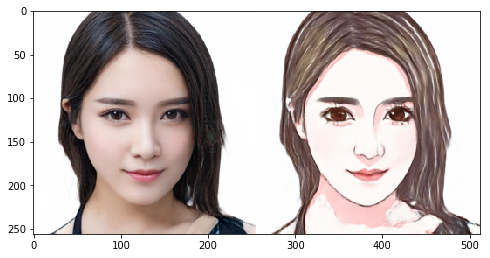

In [13]:
# 读取数据
test_names = os.listdir('data/cartoon_A2B/test')
img_name = np.random.choice(test_names)
img_A2B = cv2.imread('data/cartoon_A2B/test/'+img_name)
img_A = img_A2B[:, :256]                                  # 真人照
img_B = img_A2B[:, 256:]                                  # 卡通图

g_input = img_A.astype('float32') / 127.5 - 1             # 归一化
g_input = g_input[np.newaxis, ...].transpose(0, 3, 1, 2)  # NHWC -> NCHW
g_input = paddle.to_tensor(g_input)                       # numpy -> tensor

g_output = generator(g_input)
g_output = g_output.detach().numpy()                      # tensor -> numpy
g_output = g_output.transpose(0, 2, 3, 1)[0]              # NCHW -> NHWC
g_output = g_output * 127.5 + 127.5                       # 反归一化
g_output = g_output.astype(np.uint8)

img_show = np.hstack([img_A, g_output])[:,:,::-1]
plt.figure(figsize=(8, 8))
plt.imshow(img_show)
plt.show()